STEP 1: Loading Dataset...
 - Data Loaded. Shape: (569, 31)
 - Distribution: Benign (1): 357, Malignant (0): 212

STEP 2: Splitting Data...
 - Train Shape: (455, 30)
 - Test Shape:  (114, 30)

STEP 3: Training Baseline (Linear Kernel)...
 - Baseline Accuracy: 0.9737

STEP 4: Tuning RBF Kernel (Grid Search)...
 🏆 Best Params: {'svm__C': 10, 'svm__gamma': 0.01}
 🏆 Best Cross-Val Score: 0.9786

STEP 5: Evaluating Tuned RBF SVM...

--- Classification Report ---
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



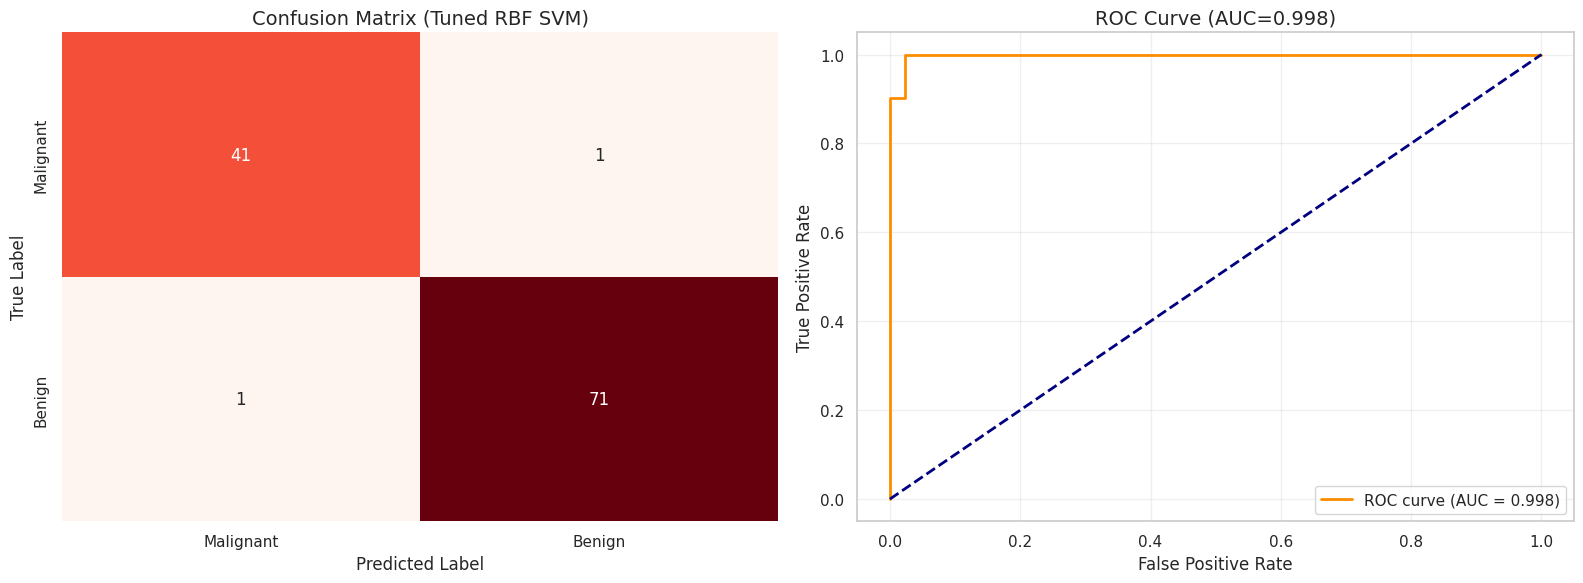


STEP 6: Saving Model...
 - Pipeline saved successfully.


In [3]:
# SVM – Breast Cancer Classification
# Dataset: Scikit-Learn Breast Cancer Wisconsin (Diagnostic)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline

# SETTING PROFESSIONAL VISUALIZATION THEME
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (14, 7)

def load_and_explore_data():
    """
    Loads dataset and handles class imbalance check.
    """
    print("STEP 1: Loading Dataset...")
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target

    # Sklearn Defaults: 0 = Malignant (Cancer), 1 = Benign (Safe)
    counts = df['target'].value_counts()
    print(f" - Data Loaded. Shape: {df.shape}")
    print(f" - Distribution: Benign (1): {counts[1]}, Malignant (0): {counts[0]}")
    return df

def split_data(df):
    """
    Splits data into Train/Test with Stratification.
    """
    print("\nSTEP 2: Splitting Data...")
    X = df.drop('target', axis=1)
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f" - Train Shape: {X_train.shape}")
    print(f" - Test Shape:  {X_test.shape}")
    return X_train, X_test, y_train, y_test

def train_baseline_linear(X_train, y_train, X_test, y_test):
    """
    Baseline: Linear SVM. Often works well for high-dimensional data.
    """
    print("\nSTEP 3: Training Baseline (Linear Kernel)...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f" - Baseline Accuracy: {score:.4f}")
    return pipeline

def grid_search_rbf(X_train, y_train):
    """
    Grid Search for RBF Kernel.
    CRITICAL CHANGE: We score based on 'f1' or 'roc_auc' to avoid the "All Benign" trap.
    """
    print("\nSTEP 4: Tuning RBF Kernel (Grid Search)...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42))
    ])

    # WIDER GRID to ensure we find the sweet spot
    param_grid = {
        'svm__C': [0.1, 1, 10, 50, 100],           # Penalty strength
        'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001] # Curve complexity
    }

    # Scoring='f1_macro' ensures we care about BOTH Malignant and Benign classes
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f" 🏆 Best Params: {grid.best_params_}")
    print(f" 🏆 Best Cross-Val Score: {grid.best_score_:.4f}")

    return grid.best_estimator_

def evaluate_model(model, X_test, y_test, model_name="Best SVM"):
    """
    Generates Confusion Matrix and ROC Curve.
    """
    print(f"\nSTEP 5: Evaluating {model_name}...")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # Probability of Benign (1)

    # Invert probabilities to show ROC for Malignant (0) detection effectively
    # Or just standard ROC is fine since it's binary.

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

    # VISUALIZATION
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[0], cbar=False)
    axes[0].set_title(f"Confusion Matrix ({model_name})", fontsize=14)
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_xticklabels(['Malignant', 'Benign'])
    axes[0].set_yticklabels(['Malignant', 'Benign'])

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve (AUC={roc_auc:.3f})', fontsize=14)
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def save_pipeline(model):
    print("\nSTEP 6: Saving Model...")
    joblib.dump(model, "breast_cancer_svm_pipeline.pkl")
    print(" - Pipeline saved successfully.")

# EXECUTION
if __name__ == "__main__":
    # 1. Load
    df_data = load_and_explore_data()

    # 2. Split
    X_tr, X_te, y_tr, y_te = split_data(df_data)

    # 3. Baseline
    train_baseline_linear(X_tr, y_tr, X_te, y_te)

    # 4. Tuning (The Champion)
    best_svm = grid_search_rbf(X_tr, y_tr)

    # 5. Evaluate
    evaluate_model(best_svm, X_te, y_te, model_name="Tuned RBF SVM")

    # 6. Save
    save_pipeline(best_svm)